# Introduction

In this notebook we will show that we can learn a MLP for predicting whether a water pump will fail in a future time window or not. The prediction / pump failure classification rate is about 95% for the following settings.

The input for the MLP is a time window of some specified length of the pump sensor data (52 sensors, called "sensor_00" till "sensor_51").

The output of the MLP is a single output neuron:
- 0 means: there will be no failure (machine status "NORMAL")
- 1 means: there will be a pump failure (machine status "BROKEN"/"RECOVERING").

The following settings are used:

In [1]:
nr_examples_to_prepare = 2000
window_width_input_minutes = 60
window_width_output_minutes = 60*24

The MLP will be trained e.g. on 2000/2=1000 training samples, where the input window covers 60 minutes (1 hour of sensor data).

The MLP input vector x length will be accordingly 60 minutes * 52 sensor samples/minute = a 3120-dimensional input vector.

The MLP output vector y length is 1 (just one output neuron).
For checking whether there was a pump failure after the input window (so for generating the teacher vectors y), we check in some time window of length 60*24 (i.e. 1 day = 60 minutes * 24 hours), whether the machine went into state "BROKEN" or "RECOVERING".

1000 randomly extracted samples (x,y) will be used for training.

1000 randomly extracted samples (x,y) will be used for testing.

For generating one of these 2000 training samples we
- randomly choose a sample minute
- compute the input vector x from the input window starting at this minute
- compute the output vector y by checking whether in the following time window the pump failed
- combine both the input and output vector into one training sample (x,y)

# Sketch of the approach

![Sketch](sketch_how_to_predict_pump_failures.png)

# Read in the sensor and machine status data

In [2]:
import pandas
print("Your Pandas version is ", pandas.__version__)
fname = "/home/juebrauer/link_to_vcd/12_datasets/pump_sensor_data/pump-sensor-data/sensor.csv"
df = pandas.read_csv( fname )

Your Pandas version is  1.0.3


In [3]:
type(df)

pandas.core.frame.DataFrame

In [4]:
# The first column has no name. Give it a name!
df.rename(columns={ df.columns[0]: "Samplenr" }, inplace = True)

In [5]:
df[:5]

,Samplenr,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


# Show some of the rows from the .csv file

In [6]:
df.head(7)

,Samplenr,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL
5,5,2018-04-01 00:05:00,2.453588,47.09201,53.1684,46.397568,637.6157,78.18568,13.41146,16.16753,...,42.70833,38.773150,63.65741,51.79398,38.773150,164.6412,66.55093,241.6088,201.6782,NORMAL
6,6,2018-04-01 00:06:00,2.455556,47.04861,53.1684,46.397568,633.3333,75.81614,13.43316,16.13136,...,43.22916,38.194440,61.92130,51.79398,39.062500,171.8750,67.70834,240.1620,200.2315,NORMAL


In [7]:
df.tail(3)

,Samplenr,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
220317,220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,...,39.06250,65.39352,48.90046,48.03241,40.798610,217.3032,155.3819,NaN,232.0602,NORMAL
220318,220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,...,40.62500,64.23611,47.74306,48.32176,40.509258,222.5116,153.9352,NaN,234.0856,NORMAL
220319,220319,2018-08-31 23:59:00,2.396528,47.69965,50.520832,43.142361,639.814800,65.45634,15.11863,16.65220,...,41.40625,62.78935,46.29630,48.90046,40.219910,227.4306,150.4630,NaN,234.0856,NORMAL


In [8]:
df.dtypes

Samplenr            int64
timestamp          object
sensor_00         float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_15         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35         float64
sensor_36   

In [9]:
df.describe()

,Samplenr,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


# Which different machine states are there and how often?

In [10]:
possible_machine_states = list(df.machine_status.unique())

In [11]:
possible_machine_states

['NORMAL', 'BROKEN', 'RECOVERING']

In [12]:
# Get all rows where machine status was "NORMAL"
df_status_NORMAL = df[ df["machine_status"] == "NORMAL" ]

In [13]:
type(df_status_NORMAL)

pandas.core.frame.DataFrame

In [14]:
df_status_NORMAL.shape

(205836, 55)

In [15]:
nr_rows_machine_status_NORMAL = df_status_NORMAL.shape[0]

In [16]:
nr_rows_machine_status_NORMAL

205836

In [17]:
nr_rows_total = df.shape[0]

In [18]:
nr_rows_total

220320

In [19]:
percent_machine_status_NORMAL = \
    (nr_rows_machine_status_NORMAL / nr_rows_total) * 100.0

In [20]:
percent_machine_status_NORMAL

93.42592592592592

In [21]:
df_status_BROKEN = df[ df["machine_status"] == "BROKEN" ]

In [22]:
df_status_BROKEN

,Samplenr,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
17155,17155,2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,...,50.78125,50.92593,51.215280,50.636570,46.006940,409.143500,121.527800,401.909700,324.6528,BROKEN
24510,24510,2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,...,42.70833,34.72222,31.539350,34.432870,33.275460,59.895830,44.560180,177.662000,183.7384,BROKEN
69318,69318,2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,...,39.06250,35.01157,37.905090,39.062500,45.428240,144.675900,49.768520,246.238400,257.5231,BROKEN
77790,77790,2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,...,202.34370,65.68287,57.870370,127.893500,153.935200,155.381900,65.682870,220.196800,267.3611,BROKEN
128040,128040,2018-06-28 22:00:00,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.335360,15.270540,...,32.29166,28.06713,28.067129,29.513889,29.224537,29.224537,29.513889,32.407406,NaN,BROKEN
141131,141131,2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,...,36.19791,37.32639,35.300930,38.194440,43.402780,99.537030,44.849540,192.129600,174.7685,BROKEN
166440,166440,2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,...,51.30208,52.10200,52.662040,67.129630,43.981480,230.324100,69.733800,NaN,205.7292,BROKEN


In [23]:
nr_rows_machine_status_BROKEN = df_status_BROKEN.shape[0]

In [24]:
print("So {0} times, the pump was broken".format(nr_rows_machine_status_BROKEN))

So 7 times, the pump was broken


In [25]:
df_status_RECOVERING = df[ df["machine_status"] == "RECOVERING" ]
nr_rows_machine_status_RECOVERING = df_status_RECOVERING.shape[0]

In [26]:
percent_machine_status_RECOVERING = \
    (nr_rows_machine_status_RECOVERING / nr_rows_total) * 100.0

In [27]:
percent_machine_status_RECOVERING

6.570896877269426

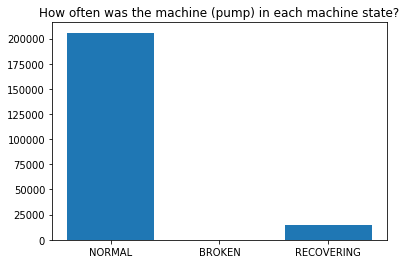

In [28]:
import matplotlib.pyplot as plt

xpos = [1,2,3]
data = [nr_rows_machine_status_NORMAL,
        nr_rows_machine_status_BROKEN,
        nr_rows_machine_status_RECOVERING]

fig, ax = plt.subplots()
ax.bar(xpos,data)
ax.set_xticks(xpos)
ax.set_xticklabels(possible_machine_states)
ax.set_title("How often was the machine (pump) in each machine state?")
plt.show()

# How long did the 7 RECOVERING phases need?

In [29]:
df_status_BROKEN

,Samplenr,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
17155,17155,2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,...,50.78125,50.92593,51.215280,50.636570,46.006940,409.143500,121.527800,401.909700,324.6528,BROKEN
24510,24510,2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,...,42.70833,34.72222,31.539350,34.432870,33.275460,59.895830,44.560180,177.662000,183.7384,BROKEN
69318,69318,2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,...,39.06250,35.01157,37.905090,39.062500,45.428240,144.675900,49.768520,246.238400,257.5231,BROKEN
77790,77790,2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,...,202.34370,65.68287,57.870370,127.893500,153.935200,155.381900,65.682870,220.196800,267.3611,BROKEN
128040,128040,2018-06-28 22:00:00,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.335360,15.270540,...,32.29166,28.06713,28.067129,29.513889,29.224537,29.224537,29.513889,32.407406,NaN,BROKEN
141131,141131,2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,...,36.19791,37.32639,35.300930,38.194440,43.402780,99.537030,44.849540,192.129600,174.7685,BROKEN
166440,166440,2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,...,51.30208,52.10200,52.662040,67.129630,43.981480,230.324100,69.733800,NaN,205.7292,BROKEN


In [30]:
row_numbers_machine_BROKEN = list(df_status_BROKEN["Samplenr"].values)

In [31]:
row_numbers_machine_BROKEN

[17155, 24510, 69318, 77790, 128040, 141131, 166440]

In [32]:
recovering_times_hours = []

for i in row_numbers_machine_BROKEN:
    print("\nMachine in status BROKEN in row: {0}".format(i) )
    
    go_further = True
    j = i
    while go_further:
        j += 1
        machine_status_in_row_j = df.iloc[j]["machine_status"]        
        if machine_status_in_row_j != "RECOVERING":
            go_further = False
            
    print("Machine went back to status {0} in row: {1}"
          .format(machine_status_in_row_j, j-i)
          )
    recovering_hours = (j-i)/60
    recovering_days  = recovering_hours / 24
    print("Machine was in RECOVERING state for {0:.1f} hours / {1:.1f} days"
          .format( recovering_hours, recovering_days )
         )
    
    recovering_times_hours.append(recovering_hours)


Machine in status BROKEN in row: 17155
Machine went back to status NORMAL in row: 945
Machine was in RECOVERING state for 15.8 hours / 0.7 days

Machine in status BROKEN in row: 24510
Machine went back to status NORMAL in row: 3111
Machine was in RECOVERING state for 51.9 hours / 2.2 days

Machine in status BROKEN in row: 69318
Machine went back to status NORMAL in row: 1313
Machine was in RECOVERING state for 21.9 hours / 0.9 days

Machine in status BROKEN in row: 77790
Machine went back to status NORMAL in row: 606
Machine was in RECOVERING state for 10.1 hours / 0.4 days

Machine in status BROKEN in row: 128040
Machine went back to status NORMAL in row: 8391
Machine was in RECOVERING state for 139.8 hours / 5.8 days

Machine in status BROKEN in row: 141131
Machine went back to status NORMAL in row: 42
Machine was in RECOVERING state for 0.7 hours / 0.0 days

Machine in status BROKEN in row: 166440
Machine went back to status NORMAL in row: 76
Machine was in RECOVERING state for 1.3

In [33]:
recovering_times_hours

[15.75, 51.85, 21.883333333333333, 10.1, 139.85, 0.7, 1.2666666666666666]

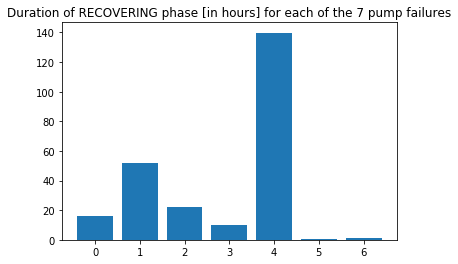

In [34]:
import matplotlib.pyplot as plt
import numpy as np

xpos = np.arange( len(recovering_times_hours) )

fig, ax = plt.subplots()
ax.bar(xpos,recovering_times_hours)
ax.set_xticks(xpos)
ax.set_xticklabels(xpos)
ax.set_title("Duration of RECOVERING phase [in hours] for each of the 7 pump failures")
plt.show()

In [35]:
min(recovering_times_hours)

0.7

In [36]:
max(recovering_times_hours)

139.85

# Visualize some of the sensor data

In [37]:
df["sensor_17"]

0         466.3284
1         466.3284
2         459.6364
3         460.8858
4         468.2206
            ...   
220315    458.3615
220316    468.4388
220317    468.6293
220318    459.7941
220319    456.5726
Name: sensor_17, Length: 220320, dtype: float64

In [38]:
type( df["sensor_17"] )

pandas.core.series.Series

In [39]:
sensor_values = list( df["sensor_17"] )

In [40]:
type(sensor_values)

list

In [41]:
len(sensor_values)

220320

In [42]:
sensor_values[:10]

[466.3284,
 466.3284,
 459.6364,
 460.8858,
 468.2206,
 461.9289,
 467.5146,
 463.8936,
 461.546,
 468.8477]

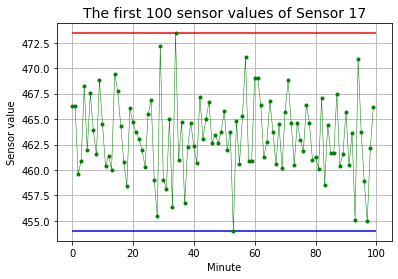

In [43]:
import matplotlib.pyplot as plt

some_few_values = sensor_values[:100]
min_val = min(some_few_values)
max_val = max(some_few_values)

plt.plot( some_few_values, color="green", linestyle="-",
          marker=".", linewidth=0.5 )
plt.hlines(min_val, 0,100, color="blue")
plt.hlines(max_val, 0,100, color="red")
plt.xlabel("Minute", fontsize=10)
plt.ylabel("Sensor value", fontsize=10)
plt.title("The first 100 sensor values of Sensor 17", fontsize=14)
plt.grid()
#plt.savefig("sensor_17.png")
plt.show()

# Fill data gaps (NaN values)

How many missing values are there in total?

In [44]:
df.isna().sum().sum()

344574

In [45]:
df.isna().sum()

Samplenr               0
timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16


In [46]:
only_numerical_cols = df.iloc[:,2:54]

In [47]:
only_numerical_cols

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
0,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
1,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
2,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037
3,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250
4,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,15.16204,...,30.208330,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NaN,231.1921
220316,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,15.11863,...,29.947920,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,NaN,231.1921
220317,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,15.11863,...,30.208330,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,NaN,232.0602
220318,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,15.11863,...,30.208332,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,NaN,234.0856


In [48]:
df.describe()

,Samplenr,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


In [49]:
fill_value = -1.0
data_with_gaps_filled = df.fillna( fill_value )

In [50]:
data_with_gaps_filled.isna().sum()

Samplenr          0
timestamp         0
sensor_00         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_15         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47         0


# Prepare data for training and testing

## How to get an example input window

In [51]:
sensordata_cols_only = data_with_gaps_filled.iloc[:,2:54]

In [52]:
sensordata_cols_only

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
0,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
1,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
2,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037
3,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250
4,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,15.65393,15.16204,...,30.208330,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,-1.0000,231.1921
220316,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,15.65393,15.11863,...,29.947920,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,-1.0000,231.1921
220317,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,15.69734,15.11863,...,30.208330,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,-1.0000,232.0602
220318,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,15.74074,15.11863,...,30.208332,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,-1.0000,234.0856


Scale data column-wise to feature range [0,1]. If all inputs are in the same range, it makes it easier for a MLP to learn.

In [53]:
from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler with feature range [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_sensor_data = scaler.fit_transform(sensordata_cols_only)

In [54]:
scaled_sensor_data

array([[0.97643798, 0.83308767, 0.95053407, ..., 0.1476298 , 0.24381179,
        0.20218671],
       [0.97643798, 0.83308767, 0.95053407, ..., 0.1476298 , 0.24381179,
        0.20218671],
       [0.97061664, 0.83759887, 0.95053407, ..., 0.14638636, 0.24207732,
        0.2044992 ],
       ...,
       [0.95703372, 0.84361368, 0.90335138, ..., 0.33600911, 0.        ,
        0.23282737],
       [0.95980576, 0.84361368, 0.90335141, ..., 0.33290067, 0.        ,
        0.23485075],
       [0.95703372, 0.84361368, 0.90335141, ..., 0.32544014, 0.        ,
        0.23485075]])

In [55]:
window_width_input_minutes = 60
window_width_output_minutes = 60*24

In [56]:
start_minute = 0
a_single_input_window = scaled_sensor_data[start_minute:start_minute+window_width_input_minutes]

In [57]:
type(a_single_input_window)

numpy.ndarray

In [58]:
# <a_single_input_window> contains the data for 60 minutes
# for each of the 52 sensors
a_single_input_window.shape

(60, 52)

In [59]:
# Map window to a vector, since we need a 1D input for the MLP
a_single_input_vector = a_single_input_window.flatten()

In [60]:
a_single_input_vector.shape

(3120,)

## How to check whether the pump failed in some time window after the input window

In [61]:
def check_for_pump_failure(start, stop):
    """
    Returns 1, if the pump failed in time window
    (start,stop)
    
    Returns 0, else.
    """
    for minute in range(start,stop):
        # get the corresponding row from the data
        machine_state_in_this_minute = df["machine_status"].iloc[minute]
        if machine_state_in_this_minute in ["BROKEN", "RECOVERING"]:
            return 1
    
    return 0

In [62]:
row_numbers_machine_BROKEN

[17155, 24510, 69318, 77790, 128040, 141131, 166440]

In [63]:
check_for_pump_failure(0,17000)

0

In [64]:
check_for_pump_failure(17000,17200)

1

In [65]:
check_for_pump_failure(20000,30000)

1

In [66]:
check_for_pump_failure(65000,69318)

0

In [67]:
check_for_pump_failure(65000,69319)

1

## Prepare example data

In [68]:
# Max row nr such that input window and output window
# still fit into the time series data?
max_row_nr = nr_rows_total-window_width_input_minutes-window_width_output_minutes

# collect the desired number of (input_vec,output_vec) examples
training_pairs = []
for example_nr in range(0,nr_examples_to_prepare):
    
    # show progress
    if example_nr % 100 == 0:
        print("Collected examples so far:", example_nr)
    
    # 1. guess a random minute
    found_example_where_pump_worked_in_input_window = False
    while not found_example_where_pump_worked_in_input_window:
    
        rnd_minute = np.random.randint(0,max_row_nr)
        
        # Make sure, the input window does not cover
        # already a phase where the machine is broken:
        # We want examples where the input window covers
        # a normal state and we want to predict whether
        # the pump will fail or not in the next time window
        # We do NOT want to collect examples where the machine is
        # already BROKEN in the input window
        # (could be too easy to predict whether the machine
        #  will be broken in the future as well)
        start = rnd_minute
        stop  = start+window_width_input_minutes
        if check_for_pump_failure(start,stop)==0:
            found_example_where_pump_worked_in_input_window = True
            
    
    # 2. get the input vector from the 2D sensor matrix data
    a_single_input_window = scaled_sensor_data[rnd_minute:rnd_minute+window_width_input_minutes]
    a_single_input_vector = a_single_input_window.flatten()
    
    # 3. check whether in time range
    #    (rnd_minute+window_width_input_minutes,
    #     rnd_minute+window_width_input_minutes+window_width_output_minutes)
    #    the pump failed
    start = rnd_minute+window_width_input_minutes
    stop  = rnd_minute+window_width_input_minutes+window_width_output_minutes
    output_value = check_for_pump_failure(start,stop)
    
    # 4. add a new training pair to list of training pairs
    training_pairs.append( (a_single_input_vector, output_value) )
    
    

Collected examples so far: 0
Collected examples so far: 100
Collected examples so far: 200
Collected examples so far: 300
Collected examples so far: 400
Collected examples so far: 500
Collected examples so far: 600
Collected examples so far: 700
Collected examples so far: 800
Collected examples so far: 900
Collected examples so far: 1000
Collected examples so far: 1100
Collected examples so far: 1200
Collected examples so far: 1300
Collected examples so far: 1400
Collected examples so far: 1500
Collected examples so far: 1600
Collected examples so far: 1700
Collected examples so far: 1800
Collected examples so far: 1900


In [69]:
len(training_pairs)

2000

## Prepare a large example data matrix D from the list of training pairs

In [70]:
input_vec_len = training_pairs[0][0].shape[0]
output_vec_len = 1


D = np.zeros( (nr_examples_to_prepare, input_vec_len+output_vec_len))
print("Shape of D is", D.shape)

# Fill data matrix D with input vec + output vec in each row
for nr in range(0,nr_examples_to_prepare):
    (x,y) = training_pairs[nr]
    D[nr,0:input_vec_len] = x
    D[nr,input_vec_len]   = y

Shape of D is (2000, 3121)


## From example data matrix get train and test matrices

In [71]:
nr_train_samples = int(nr_examples_to_prepare/2)
x_train = D[0:nr_train_samples, 0:input_vec_len]
y_train = D[0:nr_train_samples, input_vec_len]

In [72]:
x_train.shape

(1000, 3120)

In [73]:
y_train.shape

(1000,)

In [74]:
x_test = D[nr_train_samples:, 0:input_vec_len]
y_test = D[nr_train_samples:, input_vec_len]

In [75]:
x_test.shape

(1000, 3120)

In [76]:
y_test.shape

(1000,)

# Build MLP and train it

In [77]:
import tensorflow
tensorflow.__version__

'2.1.0'

Jetzt bauen wir das MLP mit Keras zusammen!

In [78]:
import tensorflow as tf
from tensorflow.keras import layers
model = tf.keras.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(input_vec_len,)) )
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='sgd',               
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

model.build()

In [79]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                156050    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 156,571
Trainable params: 156,571
Non-trainable params: 0
_________________________________________________________________


Jetzt trainieren wir das Modell!

In [80]:
history = model.fit(x_train, y_train, epochs=3000)

Train on 1000 samples
Epoch 1/3000
1000/1000 [==============================] - 0s 478us/sample - loss: 0.0877 - accuracy: 0.9430
Epoch 2/3000
1000/1000 [==============================] - 0s 238us/sample - loss: 0.0536 - accuracy: 0.9430
Epoch 3/3000
1000/1000 [==============================] - 0s 426us/sample - loss: 0.0535 - accuracy: 0.9430
Epoch 4/3000
1000/1000 [==============================] - 0s 169us/sample - loss: 0.0534 - accuracy: 0.9430
Epoch 5/3000
1000/1000 [==============================] - 0s 270us/sample - loss: 0.0534 - accuracy: 0.9430
Epoch 6/3000
1000/1000 [==============================] - 0s 208us/sample - loss: 0.0533 - accuracy: 0.9430
Epoch 7/3000
1000/1000 [==============================] - 0s 195us/sample - loss: 0.0531 - accuracy: 0.9430
Epoch 8/3000
1000/1000 [==============================] - 0s 160us/sample - loss: 0.0530 - accuracy: 0.9430
Epoch 9/3000
1000/1000 [==============================] - 0s 184us/sample - loss: 0.0530 - accuracy: 0.9430
Epoch 

In [81]:
type(history)

tensorflow.python.keras.callbacks.History

In [82]:
type(history.history)

dict

In [83]:
history.history["loss"][:20]

[0.0876733804680407,
 0.053563905239105224,
 0.053503542937338354,
 0.05344449293613434,
 0.053362548962235454,
 0.05328159449622035,
 0.05312485633045435,
 0.052951075918972496,
 0.05297786822170019,
 0.05269317715242505,
 0.052562015142291786,
 0.05249749610573053,
 0.052346537664532664,
 0.052228311624377965,
 0.052097155228257176,
 0.05217830193787813,
 0.051990933157503604,
 0.051945841282606126,
 0.051777689769864084,
 0.05180409102141857]

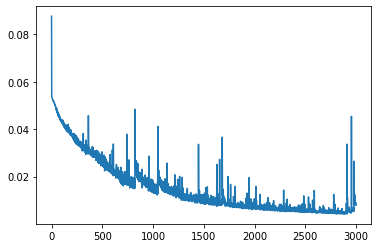

In [84]:
plt.plot(history.history["loss"])
plt.show()

# Test the final MLP

In [85]:
preds = model.predict(x_test)

In [86]:
preds.shape

(1000, 1)

In [87]:
y_test.shape

(1000,)

In [88]:
preds = preds.flatten()

In [89]:
preds.shape

(1000,)

In [90]:
preds[:20]

array([ 0.01951011, -0.01097758,  0.03920783,  0.3971027 , -0.04510723,
        0.02906281,  0.01632634,  0.0142151 ,  0.02376363,  0.43604183,
       -0.06592168,  0.6259293 ,  0.01605818,  0.03162776,  0.02470218,
        0.16662887,  0.03458759, -0.00463457,  0.01492472,  0.03810973],
      dtype=float32)

In [91]:
min(preds)

-0.16071312

In [92]:
max(preds)

1.8789523

In [93]:
pump_failure_in_future_window = 0
correctly_predicted_pump_failures = 0
correctly_predicted = 0
nr_test_samples = preds.shape[0]

tp = 0
tn = 0
fp = 0
fn = 0

for test_nr in range(0,nr_test_samples):
    ground_truth_output = y_test[test_nr]
    if preds[test_nr] < 0.5:
        predicted_output = 0.0
    else:
        predicted_output = 1.0
    print("Test example #{0}: ground truth vs. predicted machine status: {1} vs. {2}"
          .format(test_nr, ground_truth_output, predicted_output ))
    
    if predicted_output == ground_truth_output:
        correctly_predicted +=1
        
    if ground_truth_output==1:
        pump_failure_in_future_window += 1
        if predicted_output == ground_truth_output:
            correctly_predicted_pump_failures +=1
            
    if ground_truth_output==1:
        if predicted_output == ground_truth_output:
            # True positive:
            # There was a pump failure
            # and the MLP predictor predicted it
            tp+=1
        else:
            # False negative:
            # There was a pump failure
            # BUT the MLP predictor predicted it not
            fn+=1
            
    if ground_truth_output==0:        
        if predicted_output == ground_truth_output:
            # True negative:
            # There was no pump failure
            # and the MLP predictor predicted no pump failure
            tn+=1
        else:
            # False positive:
            # There was no pump failure
            # BUT the MLP predictor predicted a pump failure
            fp+=1
            
        
correct_classification_percent = (correctly_predicted/nr_test_samples)*100.0
print("\nCorrectly predicted {0} of {1} test examples --> {2}%"
      .format(correctly_predicted, nr_test_samples, correct_classification_percent))

print("\nIf there was really a pump failure in the future window,\n"
      "the MLP could predict it in {0} of the {1} pump failure (in future window) example cases."
      .format(correctly_predicted_pump_failures, pump_failure_in_future_window))

print("True positive:", tp)
print("True negative:", tn)
print("False positive:", fp)
print("False negative:", fn)

Test example #0: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #1: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #2: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #3: ground truth vs. predicted machine status: 1.0 vs. 0.0
Test example #4: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #5: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #6: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #7: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #8: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #9: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #10: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #11: ground truth vs. predicted machine status: 0.0 vs. 1.0
Test example #12: ground truth vs. predicted machine status: 0.0 vs. 0.0
Test example #13: ground truth vs. predicted machine status: 

In [94]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print("Precision: {0:.2f}".format(precision))
print("Recall   : {0:.2f}".format(recall))

Precision: 0.66
Recall   : 0.55


# Conclusion

In [95]:
print("The machine status can be predicted with an accuracy of {0}%".format(correct_classification_percent)) 

The machine status can be predicted with an accuracy of 95.89999999999999%
